In [11]:
from time import time
import importlib
import torch
import numpy as np
import torch.nn.functional as F
from typing import List
from collections import OrderedDict
from torch import nn
from torch import asin
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.dataloader import default_collate
from torchvision import datasets
from torchvision.transforms import ToTensor
import layers

# importlib.reload(layers)
from layers import LinearArcsine, RandomFeatureMap, ArcsinNN, RepresentArcsineNN, ApproxArcsineNN
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import math

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
sigmoid_indicator = lambda x: torch.sigmoid(x).float()

### Prepare data

In [4]:
"""
Download data from MNIST
"""
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

learning_rate = 5*1e-3
batch_size = 64
epochs = 20
loss_fn = nn.CrossEntropyLoss()

train_loader = DataLoader(training_data,batch_size=batch_size,collate_fn=lambda x:tuple(x_.to(device) for x_ in default_collate(x)))
test_loader = DataLoader(test_data,batch_size=batch_size,collate_fn=lambda x:tuple(x_.to(device) for x_ in default_collate(x)))

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_agg = []
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float())
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            loss_agg.append(loss)
    return loss_agg

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n accuracy_2: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

### Baseline logistic model

In [6]:
"""
Baseline: naive logistic regression
"""
acc_logistic, loss_logistic = [], []
for i in range(5):
    logistic_model = nn.Sequential(nn.Flatten(), 
                                nn.Linear(in_features = 784, out_features = 10).to(device),
                                )
    optimizer = torch.optim.Adam(params=logistic_model.parameters(), lr = learning_rate)
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, logistic_model, loss_fn, optimizer)
    acc, loss = test_loop(test_loader, logistic_model, loss_fn)
    acc_logistic.append(acc)
    loss_logistic.append(loss)

Epoch 1
-------------------------------
loss: 2.306918  [    0/60000]
loss: 0.392743  [ 6400/60000]
loss: 0.270206  [12800/60000]
loss: 0.363039  [19200/60000]
loss: 0.238284  [25600/60000]
loss: 0.379415  [32000/60000]
loss: 0.201265  [38400/60000]
loss: 0.434183  [44800/60000]
loss: 0.433200  [51200/60000]
loss: 0.426387  [57600/60000]
Epoch 2
-------------------------------
loss: 0.199788  [    0/60000]
loss: 0.299251  [ 6400/60000]
loss: 0.165983  [12800/60000]
loss: 0.291484  [19200/60000]
loss: 0.230431  [25600/60000]
loss: 0.344642  [32000/60000]
loss: 0.170752  [38400/60000]
loss: 0.413468  [44800/60000]
loss: 0.418262  [51200/60000]
loss: 0.408481  [57600/60000]
Epoch 3
-------------------------------
loss: 0.176953  [    0/60000]
loss: 0.292656  [ 6400/60000]
loss: 0.154108  [12800/60000]
loss: 0.282707  [19200/60000]
loss: 0.244059  [25600/60000]
loss: 0.328035  [32000/60000]
loss: 0.161344  [38400/60000]
loss: 0.403878  [44800/60000]
loss: 0.412689  [51200/60000]
loss: 0.40

In [8]:
print(np.mean(acc_logistic))

0.9094200000000001


### Change width

In [8]:
"""
Fix depth = 3
"""
hidden_depth = 1
width = [512, 768, 1024]

training_time = {'origin':[], 'approx_no_factoring_scratch':[], 'approx_no_factoring_retrain': [], 'approx_factoring_scratch': [], 'approx_factoring_retrain': []}
accuracy = {'origin':[], 'approx_no_factoring_scratch':[], 'approx_no_factoring_retrain': [], 'approx_factoring_scratch': [], 'approx_factoring_retrain': []}
test_loss = {'origin':[], 'approx_no_factoring_scratch':[], 'approx_no_factoring_retrain': [], 'approx_factoring_scratch': [], 'approx_factoring_retrain': []}

for w in width:
    model = ArcsinNN(in_features=784, out_features=10, hidden_features=[w]*hidden_depth, bias=False).to(device)
    approx_no_factoring_scratch = ApproxArcsineNN(model,indicator=sigmoid_indicator, seed=20220904).to(device)
    approx_factoring_scratch = RepresentArcsineNN(model, indicator=sigmoid_indicator, seed=20220904).to(device)
    approx_factoring_scratch.RandomFeatureMaps = approx_no_factoring_scratch.RandomFeatureMaps[784]
    # train model
    print("training original model")
    optimizer = torch.optim.Adam(params=model.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model, loss_fn, optimizer)
    end = time()
    training_time['origin'].append(end - start)
    acc, loss = test_loop(test_loader, model, loss_fn)
    accuracy['origin'].append(acc)
    test_loss['origin'].append(loss)

    # train approx_scractch
    print("training approx_no_factoring_scratch model")
    optimizer = torch.optim.Adam(params=approx_no_factoring_scratch.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_no_factoring_scratch, loss_fn, optimizer)
    end = time()
    training_time['approx_no_factoring_scratch'].append(end - start)
    acc, loss = test_loop(test_loader, approx_no_factoring_scratch, loss_fn)
    accuracy['approx_no_factoring_scratch'].append(acc)
    test_loss['approx_no_factoring_scratch'].append(loss)

    # train approx_factoring_scratch
    print("training approx_factoring_scratch model")
    optimizer = torch.optim.Adam(params=approx_factoring_scratch.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_factoring_scratch, loss_fn, optimizer)
    end = time()
    training_time['approx_factoring_scratch'].append(end - start)
    acc, loss = test_loop(test_loader, approx_factoring_scratch, loss_fn)
    accuracy['approx_factoring_scratch'].append(acc)
    test_loss['approx_factoring_scratch'].append(loss)

    approx_no_factoring_retrain = ApproxArcsineNN(model,indicator=sigmoid_indicator, seed=20220904).to(device)
    approx_factoring_retrain = RepresentArcsineNN(model,indicator=sigmoid_indicator, seed=20220904).to(device)
    approx_factoring_retrain.RandomFeatureMaps = approx_no_factoring_retrain.RandomFeatureMaps[784]

    # train approx_no_factoring_retrain
    print("training approx_factoring_scratch model")
    optimizer = torch.optim.Adam(params=approx_no_factoring_retrain.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_no_factoring_retrain, loss_fn, optimizer)
    end = time()
    training_time['approx_no_factoring_retrain'].append(end - start)
    acc, loss = test_loop(test_loader, approx_no_factoring_retrain, loss_fn)
    accuracy['approx_no_factoring_retrain'].append(acc)
    test_loss['approx_no_factoring_retrain'].append(loss)

    # train approx_factoring_retrain
    print("training approx_factoring_retrain model")
    optimizer = torch.optim.Adam(params=approx_factoring_retrain.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_factoring_retrain, loss_fn, optimizer)
    end = time()
    training_time['approx_factoring_retrain'].append(end - start)
    acc, loss = test_loop(test_loader, approx_factoring_retrain, loss_fn)
    accuracy['approx_factoring_retrain'].append(acc)
    test_loss['approx_factoring_retrain'].append(loss)

training original model
Epoch 1
-------------------------------
loss: 2.303188  [    0/60000]
loss: 0.294557  [ 6400/60000]
loss: 0.280907  [12800/60000]
loss: 0.297293  [19200/60000]
loss: 0.264598  [25600/60000]
loss: 0.413781  [32000/60000]
loss: 0.267576  [38400/60000]
loss: 0.481940  [44800/60000]
loss: 0.542462  [51200/60000]
loss: 0.431125  [57600/60000]
Epoch 2
-------------------------------
loss: 0.243240  [    0/60000]
loss: 0.298094  [ 6400/60000]
loss: 0.163223  [12800/60000]
loss: 0.293408  [19200/60000]
loss: 0.250148  [25600/60000]
loss: 0.387086  [32000/60000]
loss: 0.226193  [38400/60000]
loss: 0.466351  [44800/60000]
loss: 0.437093  [51200/60000]
loss: 0.415716  [57600/60000]
Epoch 3
-------------------------------
loss: 0.203829  [    0/60000]
loss: 0.293498  [ 6400/60000]
loss: 0.147117  [12800/60000]
loss: 0.289370  [19200/60000]
loss: 0.253411  [25600/60000]
loss: 0.365509  [32000/60000]
loss: 0.214787  [38400/60000]
loss: 0.453031  [44800/60000]
loss: 0.395031  

In [12]:
accuracy

{'origin': [0.9199, 0.919, 0.9184],
 'approx_no_factoring_scratch': [0.9375, 0.9389, 0.9399],
 'approx_no_factoring_retrain': [0.9379, 0.9392, 0.9407],
 'approx_factoring_scratch': [0.941, 0.9405, 0.9409],
 'approx_factoring_retrain': [0.9379, 0.9406, 0.9404]}

In [13]:
test_loss

{'origin': [0.28039878174947325, 0.284292417050452, 0.2865259483765075],
 'approx_no_factoring_scratch': [0.20232544166991,
  0.20047518247619842,
  0.2010483508455051],
 'approx_no_factoring_retrain': [0.2130214566673348,
  0.20503204627033728,
  0.20135129043820557],
 'approx_factoring_scratch': [0.20122907483938393,
  0.2022432048128811,
  0.20018171539803029],
 'approx_factoring_retrain': [0.21237662740668672,
  0.20791684758143536,
  0.20113769647588206]}

In [14]:
training_time

{'origin': [180.41324853897095, 179.55577111244202, 177.77302885055542],
 'approx_no_factoring_scratch': [178.64846634864807,
  181.50544095039368,
  175.74321746826172],
 'approx_no_factoring_retrain': [176.99033522605896,
  180.95192742347717,
  174.25983595848083],
 'approx_factoring_scratch': [184.05366444587708,
  181.2962498664856,
  177.628919839859],
 'approx_factoring_retrain': [182.45630717277527,
  181.58651328086853,
  177.81710934638977]}

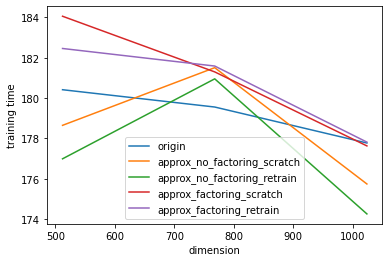

In [9]:
for key in training_time:
    plt.plot(width, training_time[key], label = key)
plt.legend()
plt.xlabel('dimension')
plt.ylabel('training time')
plt.show()

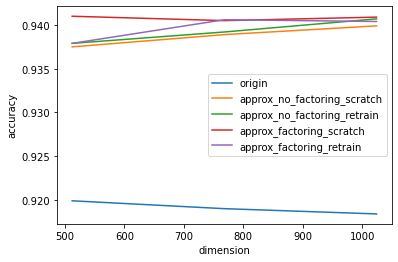

In [10]:
for key in accuracy:
    plt.plot(width, accuracy[key], label = key)
plt.legend()
plt.xlabel('dimension')
plt.ylabel('accuracy')
plt.show()

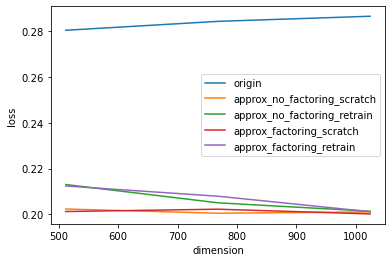

In [11]:
for key in test_loss:
    plt.plot(width, test_loss[key], label = key)
plt.legend()
plt.xlabel('dimension')
plt.ylabel('loss')
plt.show()

### Ignore 1st layer approximation

In [8]:
"""
Fix depth = 3
"""
hidden_depth = 3
width = [512, 768, 1024, 2048, 4096]

res_time = []
res_acc = []
res_loss = []
for i in range(3):
    training_time = {'origin':[], 'approx_no_factoring_scratch':[], 'approx_no_factoring_retrain': [], 'approx_factoring_scratch': [], 'approx_factoring_retrain': []}
    accuracy = {'origin':[], 'approx_no_factoring_scratch':[], 'approx_no_factoring_retrain': [], 'approx_factoring_scratch': [], 'approx_factoring_retrain': []}
    test_loss = {'origin':[], 'approx_no_factoring_scratch':[], 'approx_no_factoring_retrain': [], 'approx_factoring_scratch': [], 'approx_factoring_retrain': []}
    for w in width:
        model = ArcsinNN(in_features=784, out_features=10, hidden_features=[4096] + [w]*(hidden_depth-1), bias=False).to(device)
        approx_no_factoring_scratch = ApproxArcsineNN(model,indicator=sigmoid_indicator, seed=20220904).to(device)
        approx_factoring_scratch = RepresentArcsineNN(model, indicator=sigmoid_indicator, seed=20220904, ignore_first_layer=True).to(device)
        # train model
        print("training original model")
        optimizer = torch.optim.Adam(params=model.parameters(),lr=learning_rate)
        start = time()
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(train_loader, model, loss_fn, optimizer)
        end = time()
        training_time['origin'].append(end - start)
        acc, loss = test_loop(test_loader, model, loss_fn)
        accuracy['origin'].append(acc)
        test_loss['origin'].append(loss)

        # train approx_scractch
        print("training approx_no_factoring_scratch model")
        optimizer = torch.optim.Adam(params=approx_no_factoring_scratch.parameters(),lr=learning_rate)
        start = time()
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(train_loader, approx_no_factoring_scratch, loss_fn, optimizer)
        end = time()
        training_time['approx_no_factoring_scratch'].append(end - start)
        acc, loss = test_loop(test_loader, approx_no_factoring_scratch, loss_fn)
        accuracy['approx_no_factoring_scratch'].append(acc)
        test_loss['approx_no_factoring_scratch'].append(loss)

        # train approx_factoring_scratch
        print("training approx_factoring_scratch model")
        optimizer = torch.optim.Adam(params=approx_factoring_scratch.parameters(),lr=learning_rate)
        start = time()
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(train_loader, approx_factoring_scratch, loss_fn, optimizer)
        end = time()
        training_time['approx_factoring_scratch'].append(end - start)
        acc, loss = test_loop(test_loader, approx_factoring_scratch, loss_fn)
        accuracy['approx_factoring_scratch'].append(acc)
        test_loss['approx_factoring_scratch'].append(loss)

        approx_no_factoring_retrain = ApproxArcsineNN(model,indicator=sigmoid_indicator, seed=20220904).to(device)
        approx_factoring_retrain = RepresentArcsineNN(model,indicator=sigmoid_indicator, seed=20220904, ignore_first_layer=True).to(device)

        # train approx_no_factoring_retrain
        print("training approx_factoring_scratch model")
        optimizer = torch.optim.Adam(params=approx_no_factoring_retrain.parameters(),lr=learning_rate)
        start = time()
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(train_loader, approx_no_factoring_retrain, loss_fn, optimizer)
        end = time()
        training_time['approx_no_factoring_retrain'].append(end - start)
        acc, loss = test_loop(test_loader, approx_no_factoring_retrain, loss_fn)
        accuracy['approx_no_factoring_retrain'].append(acc)
        test_loss['approx_no_factoring_retrain'].append(loss)

        # train approx_factoring_retrain
        print("training approx_factoring_retrain model")
        optimizer = torch.optim.Adam(params=approx_factoring_retrain.parameters(),lr=learning_rate)
        start = time()
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(train_loader, approx_factoring_retrain, loss_fn, optimizer)
        end = time()
        training_time['approx_factoring_retrain'].append(end - start)
        acc, loss = test_loop(test_loader, approx_factoring_retrain, loss_fn)
        accuracy['approx_factoring_retrain'].append(acc)
        test_loss['approx_factoring_retrain'].append(loss)
    res_time.append(training_time) 
    res_loss.append(accuracy)
    res_acc.append(test_loss)

training original model
Epoch 1
-------------------------------
loss: 2.308424  [    0/60000]
loss: 0.418666  [ 6400/60000]
loss: 0.410619  [12800/60000]
loss: 0.420229  [19200/60000]
loss: 0.426149  [25600/60000]
loss: 0.583656  [32000/60000]
loss: 0.367128  [38400/60000]
loss: 0.389559  [44800/60000]
loss: 0.525135  [51200/60000]
loss: 0.446430  [57600/60000]
Epoch 2
-------------------------------
loss: 0.261576  [    0/60000]
loss: 0.316187  [ 6400/60000]
loss: 0.155758  [12800/60000]
loss: 0.334396  [19200/60000]
loss: 0.297526  [25600/60000]
loss: 0.429906  [32000/60000]
loss: 0.288566  [38400/60000]
loss: 0.363601  [44800/60000]
loss: 0.495419  [51200/60000]
loss: 0.378473  [57600/60000]
Epoch 3
-------------------------------
loss: 0.225496  [    0/60000]
loss: 0.293098  [ 6400/60000]
loss: 0.135026  [12800/60000]
loss: 0.282261  [19200/60000]
loss: 0.295094  [25600/60000]
loss: 0.366034  [32000/60000]
loss: 0.245703  [38400/60000]
loss: 0.363597  [44800/60000]
loss: 0.474830  

In [24]:
width = [512, 768, 1024, 2048, 4096]

In [11]:
res_acc_avg = {key: np.mean(np.array([res_loss[i][key] for i in range(3)]),axis=0) for key in accuracy}
res_acc_avg

{'origin': array([0.93193333, 0.93203333, 0.9305    , 0.92806667, 0.92336667]),
 'approx_no_factoring_scratch': array([0.9739    , 0.9732    , 0.9748    , 0.97506667, 0.97036667]),
 'approx_no_factoring_retrain': array([0.95853333, 0.958     , 0.9576    , 0.9576    , 0.95863333]),
 'approx_factoring_scratch': array([0.965     , 0.96546667, 0.96466667, 0.96086667, 0.96316667]),
 'approx_factoring_retrain': array([0.9649    , 0.96326667, 0.96486667, 0.96303333, 0.96366667])}

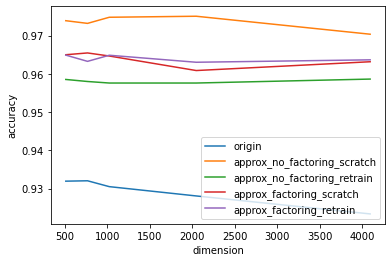

In [12]:
for key in res_acc_avg:
    plt.plot(width, res_acc_avg[key])
plt.legend(res_acc_avg.keys())
plt.xlabel('dimension')
plt.ylabel('accuracy')
plt.show()

In [22]:
res_time_avg = {key: np.mean(np.array([res_time[i][key] for i in range(3)]),axis=0) for key in accuracy}
res_time_avg

{'origin': array([212.70000768, 214.21193878, 213.53397624, 214.63697863,
        419.20597386]),
 'approx_no_factoring_scratch': array([ 211.25139761,  266.61454511,  333.0548617 ,  699.83207798,
        2005.28539697]),
 'approx_no_factoring_retrain': array([ 211.10742704,  267.66845338,  324.70998152,  691.27227052,
        1951.88025228]),
 'approx_factoring_scratch': array([ 422.58322684,  591.33234111,  764.63421933, 1645.46245726,
        3741.43278861]),
 'approx_factoring_retrain': array([ 426.45847638,  593.67187301,  745.89205821, 1666.73611752,
        3717.93431973])}

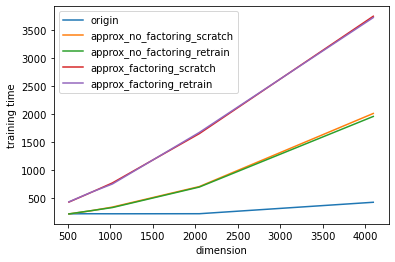

In [25]:
for key in res_time_avg:
    plt.plot(width, res_time_avg[key])
plt.legend(res_time_avg.keys())
plt.xlabel('dimension')
plt.ylabel('training time')
plt.show()

In [26]:
res_loss_avg = {key: np.mean(np.array([res_acc[i][key] for i in range(3)]),axis=0) for key in accuracy}
res_loss_avg

{'origin': array([0.22007518, 0.22039735, 0.22405485, 0.23565723, 0.24978009]),
 'approx_no_factoring_scratch': array([0.20753808, 0.21048438, 0.20403091, 0.2179896 , 0.21276077]),
 'approx_no_factoring_retrain': array([0.16091369, 0.17125451, 0.18407114, 0.21040418, 0.23742796]),
 'approx_factoring_scratch': array([0.1202825 , 0.11640885, 0.11827608, 0.13483686, 0.12752827]),
 'approx_factoring_retrain': array([0.11787693, 0.12914237, 0.12183895, 0.12669052, 0.12432351])}

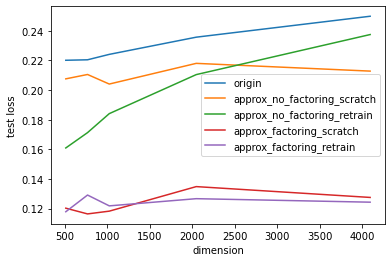

In [27]:
for key in res_loss_avg:
    plt.plot(width, res_loss_avg[key])
plt.legend(res_loss_avg.keys())
plt.xlabel('dimension')
plt.ylabel('test loss')
plt.show()

### Increase feature map projection dimension

In [8]:
"""
Fix depth = 2
"""
hidden_depth = 2
width = 1024
project_dims = [784, 1024, 2048, 4096, 7680, 10000]

res_time_2 = []
res_acc_2 = []
res_loss_2 = []
for i in range(3):
    training_time = {'origin':[], 'approx_no_factoring_scratch':[], 'approx_no_factoring_retrain': [], 'approx_factoring_scratch': [], 'approx_factoring_retrain': []}
    accuracy = {'origin':[], 'approx_no_factoring_scratch':[], 'approx_no_factoring_retrain': [], 'approx_factoring_scratch': [], 'approx_factoring_retrain': []}
    test_loss = {'origin':[], 'approx_no_factoring_scratch':[], 'approx_no_factoring_retrain': [], 'approx_factoring_scratch': [], 'approx_factoring_retrain': []}
    for project_dim in project_dims:
        model = ArcsinNN(in_features=784, out_features=10, hidden_features=[width]*hidden_depth, bias=False).to(device)
        approx_no_factoring_scratch = ApproxArcsineNN(model,indicator=sigmoid_indicator, seed=20220904, project_dim=project_dim).to(device)
        approx_factoring_scratch = RepresentArcsineNN(model, indicator=sigmoid_indicator, seed=20220904, project_dim=project_dim).to(device)
        # train model
        print("training original model")
        optimizer = torch.optim.Adam(params=model.parameters(),lr=learning_rate)
        start = time()
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(train_loader, model, loss_fn, optimizer)
        end = time()
        training_time['origin'].append(end - start)
        acc, loss = test_loop(test_loader, model, loss_fn)
        accuracy['origin'].append(acc)
        test_loss['origin'].append(loss)

        # train approx_scractch
        print("training approx_no_factoring_scratch model")
        optimizer = torch.optim.Adam(params=approx_no_factoring_scratch.parameters(),lr=learning_rate)
        start = time()
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(train_loader, approx_no_factoring_scratch, loss_fn, optimizer)
        end = time()
        training_time['approx_no_factoring_scratch'].append(end - start)
        acc, loss = test_loop(test_loader, approx_no_factoring_scratch, loss_fn)
        accuracy['approx_no_factoring_scratch'].append(acc)
        test_loss['approx_no_factoring_scratch'].append(loss)

        # train approx_factoring_scratch
        print("training approx_factoring_scratch model")
        optimizer = torch.optim.Adam(params=approx_factoring_scratch.parameters(),lr=learning_rate)
        start = time()
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(train_loader, approx_factoring_scratch, loss_fn, optimizer)
        end = time()
        training_time['approx_factoring_scratch'].append(end - start)
        acc, loss = test_loop(test_loader, approx_factoring_scratch, loss_fn)
        accuracy['approx_factoring_scratch'].append(acc)
        test_loss['approx_factoring_scratch'].append(loss)

        approx_no_factoring_retrain = ApproxArcsineNN(model,indicator=sigmoid_indicator, seed=20220904, project_dim=project_dim).to(device)
        approx_factoring_retrain = RepresentArcsineNN(model,indicator=sigmoid_indicator, seed=20220904, project_dim=project_dim).to(device)

        # train approx_no_factoring_retrain
        print("training approx_no_factoring_retrain model")
        optimizer = torch.optim.Adam(params=approx_no_factoring_retrain.parameters(),lr=learning_rate)
        start = time()
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(train_loader, approx_no_factoring_retrain, loss_fn, optimizer)
        end = time()
        training_time['approx_no_factoring_retrain'].append(end - start)
        acc, loss = test_loop(test_loader, approx_no_factoring_retrain, loss_fn)
        accuracy['approx_no_factoring_retrain'].append(acc)
        test_loss['approx_no_factoring_retrain'].append(loss)

        # train approx_factoring_retrain
        print("training approx_factoring_retrain model")
        optimizer = torch.optim.Adam(params=approx_factoring_retrain.parameters(),lr=learning_rate)
        start = time()
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(train_loader, approx_factoring_retrain, loss_fn, optimizer)
        end = time()
        training_time['approx_factoring_retrain'].append(end - start)
        acc, loss = test_loop(test_loader, approx_factoring_retrain, loss_fn)
        accuracy['approx_factoring_retrain'].append(acc)
        test_loss['approx_factoring_retrain'].append(loss)
    res_time_2.append(training_time) 
    res_loss_2.append(test_loss)
    res_acc_2.append(accuracy)

training original model
Epoch 1
-------------------------------
loss: 2.302043  [    0/60000]
loss: 0.420404  [ 6400/60000]
loss: 0.288917  [12800/60000]
loss: 0.350745  [19200/60000]
loss: 0.369238  [25600/60000]
loss: 0.521526  [32000/60000]
loss: 0.367939  [38400/60000]
loss: 0.339225  [44800/60000]
loss: 0.530308  [51200/60000]
loss: 0.480678  [57600/60000]
Epoch 2
-------------------------------
loss: 0.194226  [    0/60000]
loss: 0.281263  [ 6400/60000]
loss: 0.205124  [12800/60000]
loss: 0.288181  [19200/60000]
loss: 0.320683  [25600/60000]
loss: 0.451285  [32000/60000]
loss: 0.283871  [38400/60000]
loss: 0.367825  [44800/60000]
loss: 0.473802  [51200/60000]
loss: 0.419284  [57600/60000]
Epoch 3
-------------------------------
loss: 0.193949  [    0/60000]
loss: 0.276625  [ 6400/60000]
loss: 0.166817  [12800/60000]
loss: 0.281209  [19200/60000]
loss: 0.324622  [25600/60000]
loss: 0.395938  [32000/60000]
loss: 0.240301  [38400/60000]
loss: 0.372215  [44800/60000]
loss: 0.450969  

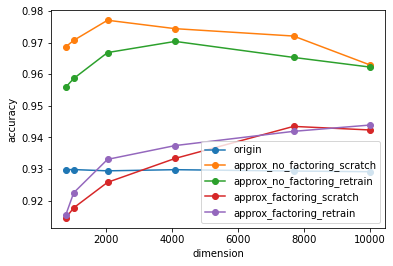

In [9]:
res_acc_avg_2 = {key: np.mean(np.array([res_acc_2[i][key] for i in range(3)]),axis=0) for key in accuracy}
for key in res_acc_avg_2:
    plt.plot(project_dims, res_acc_avg_2[key], "-o")
plt.legend(res_acc_avg_2.keys())
plt.xlabel('dimension')
plt.ylabel('accuracy')
plt.show()

{'origin': array([192.6986951 , 190.2369957 , 190.51654092, 190.34926947,
       190.10020789, 194.12111012]), 'approx_no_factoring_scratch': array([188.3621908 , 190.86155963, 190.40550653, 190.85381118,
       237.55499768, 316.97120969]), 'approx_no_factoring_retrain': array([187.40772462, 190.52535629, 191.10170118, 192.1061759 ,
       242.34620372, 320.56262692]), 'approx_factoring_scratch': array([ 182.84010839,  191.97148085,  188.77779921,  340.75619419,
        951.65118504, 1558.29750506]), 'approx_factoring_retrain': array([ 184.94875518,  191.79535429,  188.7722884 ,  342.09661182,
        970.58417527, 1555.54482945])}


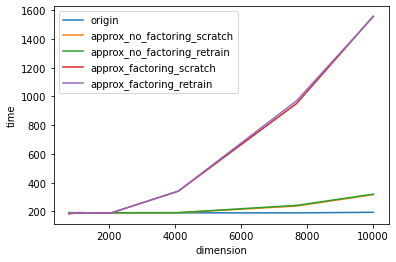

In [10]:
res_time_avg_2 = {key: np.mean(np.array([res_time_2[i][key] for i in range(3)]),axis=0) for key in accuracy}
print(res_time_avg_2)
for key in res_time_avg_2:
    plt.plot(project_dims, res_time_avg_2[key])
plt.legend(res_time_avg_2.keys())
plt.xlabel('dimension')
plt.ylabel('time')
plt.show()

### Training dynamics of "kernel" matrix

In [6]:
"""
Fix depth = 2
Change project dimension
"""
hidden_depth = 2
width = 1024
project_dims = [1024, 10000]

kernels_scratch = {d:[] for d in project_dims}
kernels_retrain = {d:[] for d in project_dims}    
for d in project_dims:
    model = ArcsinNN(in_features=784, out_features=10, hidden_features=[width]*hidden_depth, bias=False).to(device)
    approx_factoring_scratch = RepresentArcsineNN(model, indicator=sigmoid_indicator, seed=20220904, project_dim=d).to(device)
    
    # train model
    print("training original model")
    optimizer = torch.optim.Adam(params=model.parameters(),lr=learning_rate)
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model, loss_fn, optimizer)

    # train approx_factoring_scratch
    print("training approx_factoring_scratch model")
    optimizer = torch.optim.Adam(params=approx_factoring_scratch.parameters(),lr=learning_rate)
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_factoring_scratch, loss_fn, optimizer)
        
        W = torch.eye(approx_factoring_scratch.Linears[0].weight.shape[1], device=approx_factoring_scratch.Linears[0].weight.device)
        for i in range(approx_factoring_scratch.num_hidden_layers):
            # compute phi(phi(...phi(W)))
            W = torch.matmul(approx_factoring_scratch.Linears[i].weight.clone().detach(), W)
            W = approx_factoring_scratch.RandomFeatureMaps[W.shape[1]](W)
            W = (torch.pi/2/W.shape[1]) * W
        # W = torch.matmul(approx_factoring_scratch.Output.weight.clone().detach(), W)
        kernels_scratch[d].append(W)

    approx_factoring_retrain = RepresentArcsineNN(model,indicator=sigmoid_indicator, seed=20220904, project_dim=d).to(device)

    # train approx_factoring_retrain
    print("training approx_factoring_retrain model")
    optimizer = torch.optim.Adam(params=approx_factoring_retrain.parameters(),lr=learning_rate)
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_factoring_retrain, loss_fn, optimizer)

        W = torch.eye(approx_factoring_retrain.Linears[0].weight.shape[1], device=approx_factoring_retrain.Linears[0].weight.device)
        for i in range(approx_factoring_retrain.num_hidden_layers):
            # compute phi(phi(...phi(W)))
            W = torch.matmul(approx_factoring_retrain.Linears[i].weight.clone().detach(), W)
            W = approx_factoring_retrain.RandomFeatureMaps[W.shape[1]](W)
            W = (torch.pi/2/W.shape[1]) * W
        # W = torch.matmul(approx_factoring_retrain.Output.weight.clone().detach(), W)
        kernels_retrain[d].append(W)

training original model
Epoch 1
-------------------------------
loss: 2.300730  [    0/60000]
loss: 0.430540  [ 6400/60000]
loss: 0.287679  [12800/60000]
loss: 0.347412  [19200/60000]
loss: 0.367690  [25600/60000]
loss: 0.519567  [32000/60000]
loss: 0.368956  [38400/60000]
loss: 0.337355  [44800/60000]
loss: 0.534331  [51200/60000]
loss: 0.484967  [57600/60000]
Epoch 2
-------------------------------
loss: 0.194658  [    0/60000]
loss: 0.281563  [ 6400/60000]
loss: 0.208303  [12800/60000]
loss: 0.288696  [19200/60000]
loss: 0.319672  [25600/60000]
loss: 0.453502  [32000/60000]
loss: 0.287325  [38400/60000]
loss: 0.364395  [44800/60000]
loss: 0.478192  [51200/60000]
loss: 0.422271  [57600/60000]
Epoch 3
-------------------------------
loss: 0.193088  [    0/60000]
loss: 0.273490  [ 6400/60000]
loss: 0.168640  [12800/60000]
loss: 0.280755  [19200/60000]
loss: 0.325278  [25600/60000]
loss: 0.399258  [32000/60000]
loss: 0.242552  [38400/60000]
loss: 0.369682  [44800/60000]
loss: 0.454840  

In [7]:
svdvals_scratch = {d: [torch.linalg.svdvals(A) for A in kernels_scratch[d]] for d in project_dims}
svdvals_retrain = {d: [torch.linalg.svdvals(A) for A in kernels_retrain[d]] for d in project_dims}
svdvals_dict = {
    "scratch_start_1024": svdvals_scratch[1024][0],
    "scratch_end_1024": svdvals_scratch[1024][-1],
    "scratch_start_10000": svdvals_scratch[10000][0],
    "scratch_end_10000": svdvals_scratch[10000][-1],
    "retrain_start_1024": svdvals_retrain[1024][0],
    "retrain_end_1024": svdvals_retrain[1024][-1],
    "retrain_start_10000": svdvals_retrain[10000][0],
    "retrain_end_10000": svdvals_retrain[10000][-1],
}

Text(0, 0.5, 'singlar value')

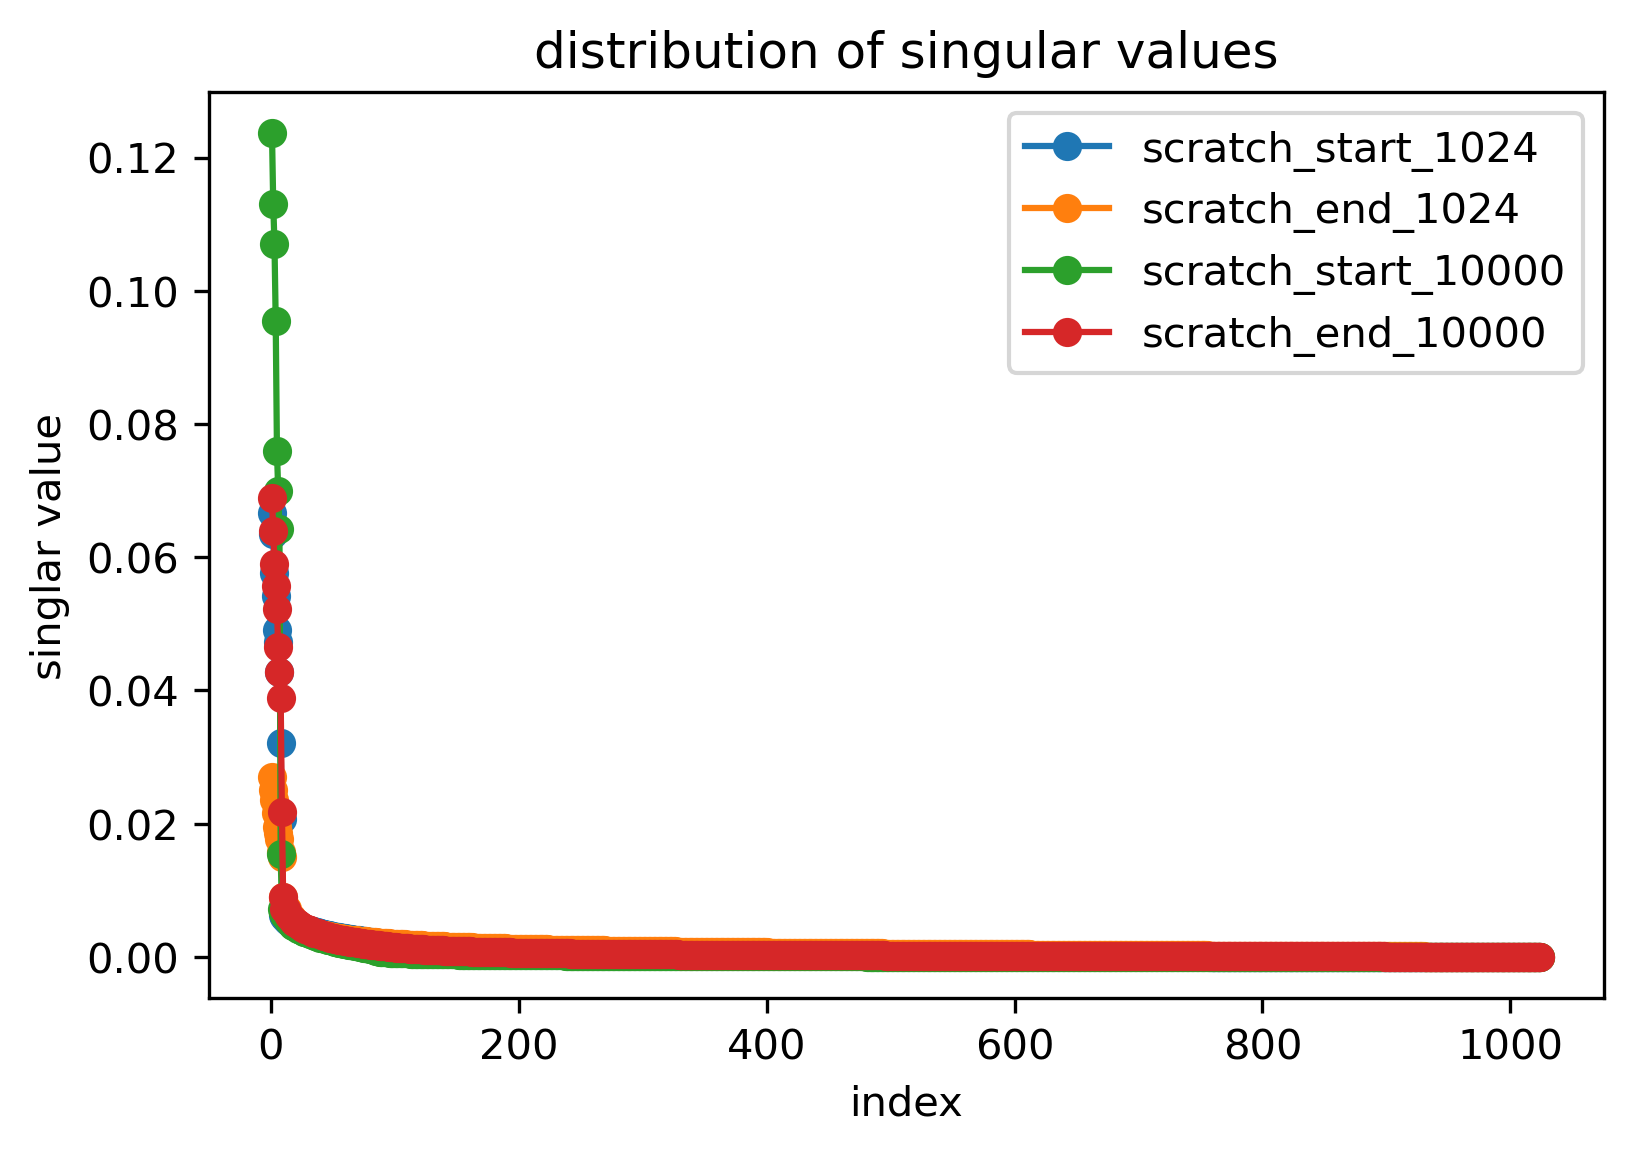

In [34]:
index = np.arange(1,1025)
keys = ["scratch_start_1024", "scratch_end_1024", "scratch_start_10000", "scratch_end_10000"]
for x in keys:
    plt.plot(index, svdvals_dict[x].cpu()/torch.sum(svdvals_dict[x].cpu()), '-o')
plt.legend(keys)
plt.title("distribution of singular values")
plt.xlabel("index")
plt.ylabel("singlar value")

Text(0, 0.5, 'singlar value')

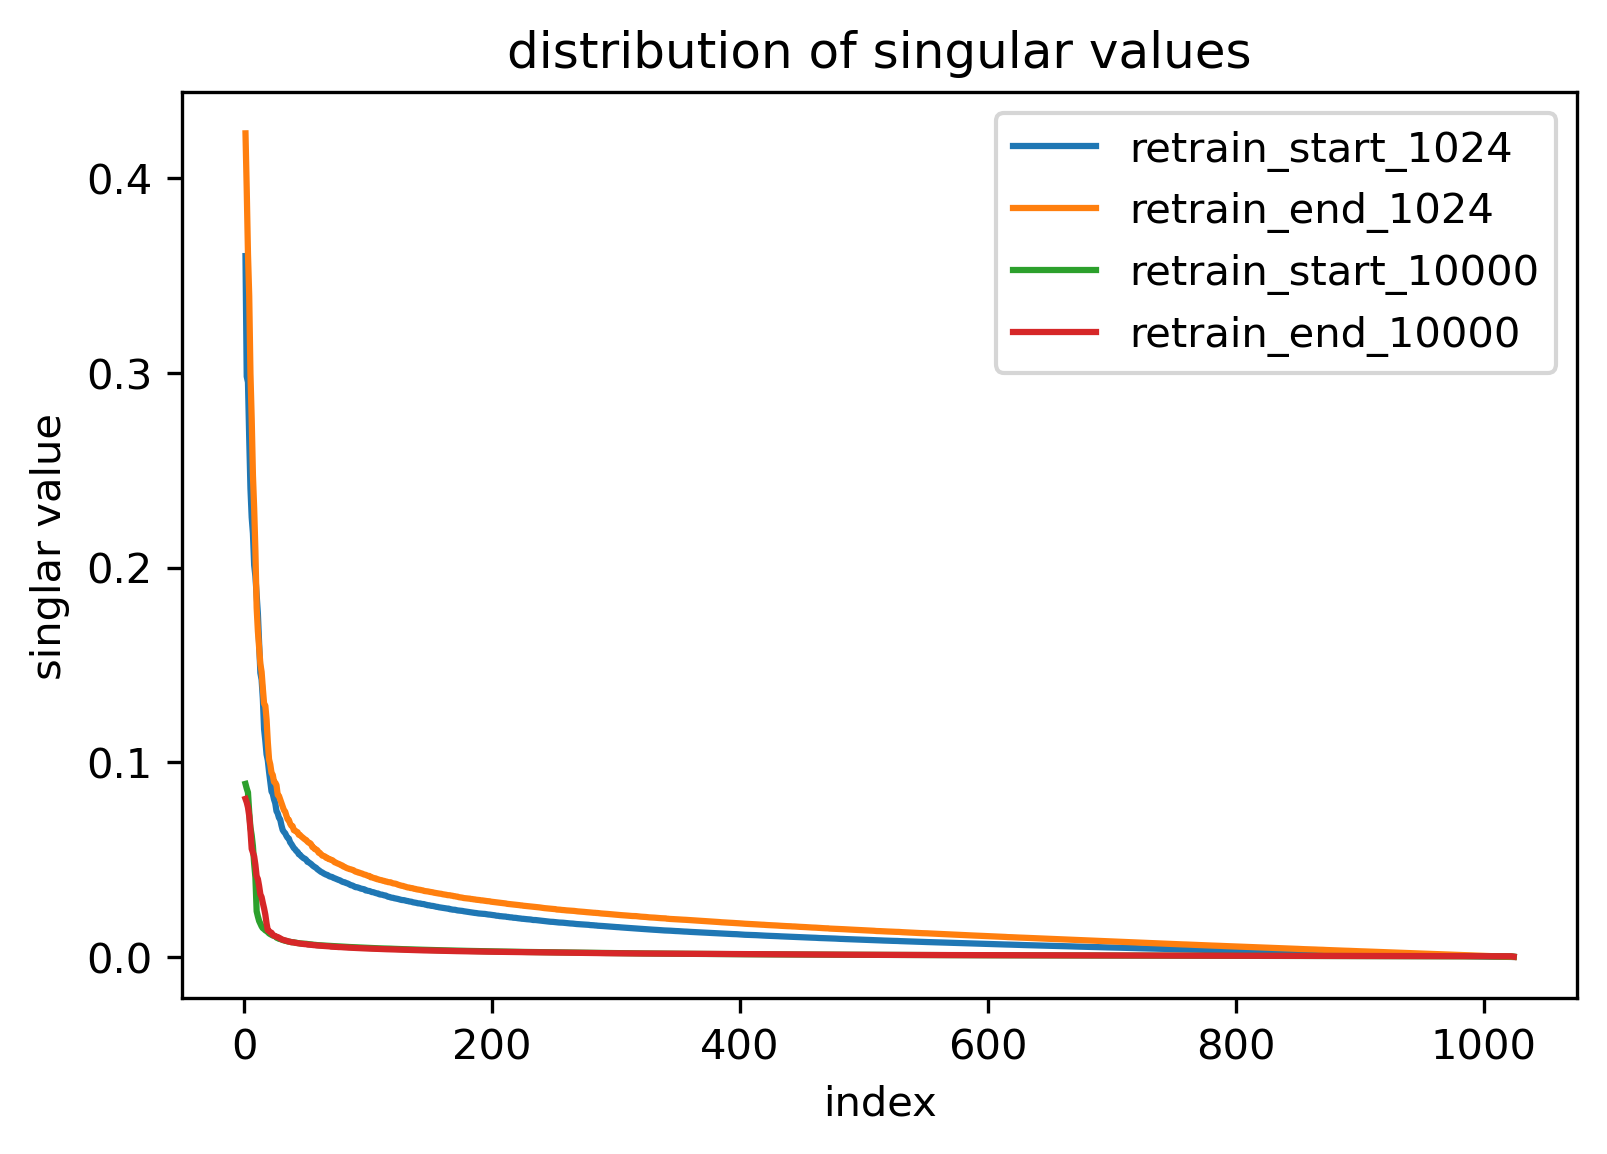

In [30]:
index = np.arange(1,1025)
keys = ["retrain_start_1024", "retrain_end_1024", "retrain_start_10000", "retrain_end_10000"]
for x in keys:
    plt.plot(index, svdvals_dict[x].cpu()/)
plt.legend(keys)
plt.title("distribution of singular values")
plt.xlabel("index")
plt.ylabel("singlar value")

In [9]:
nuc_norms_scratch = {d: [torch.sum(x).cpu() for x in svdvals_scratch[d]] for d in project_dims}
nuc_norms_retrain = {d: [torch.sum(x).cpu() for x in svdvals_retrain[d]] for d in project_dims}

Text(0, 0.5, 'nuclear norm')

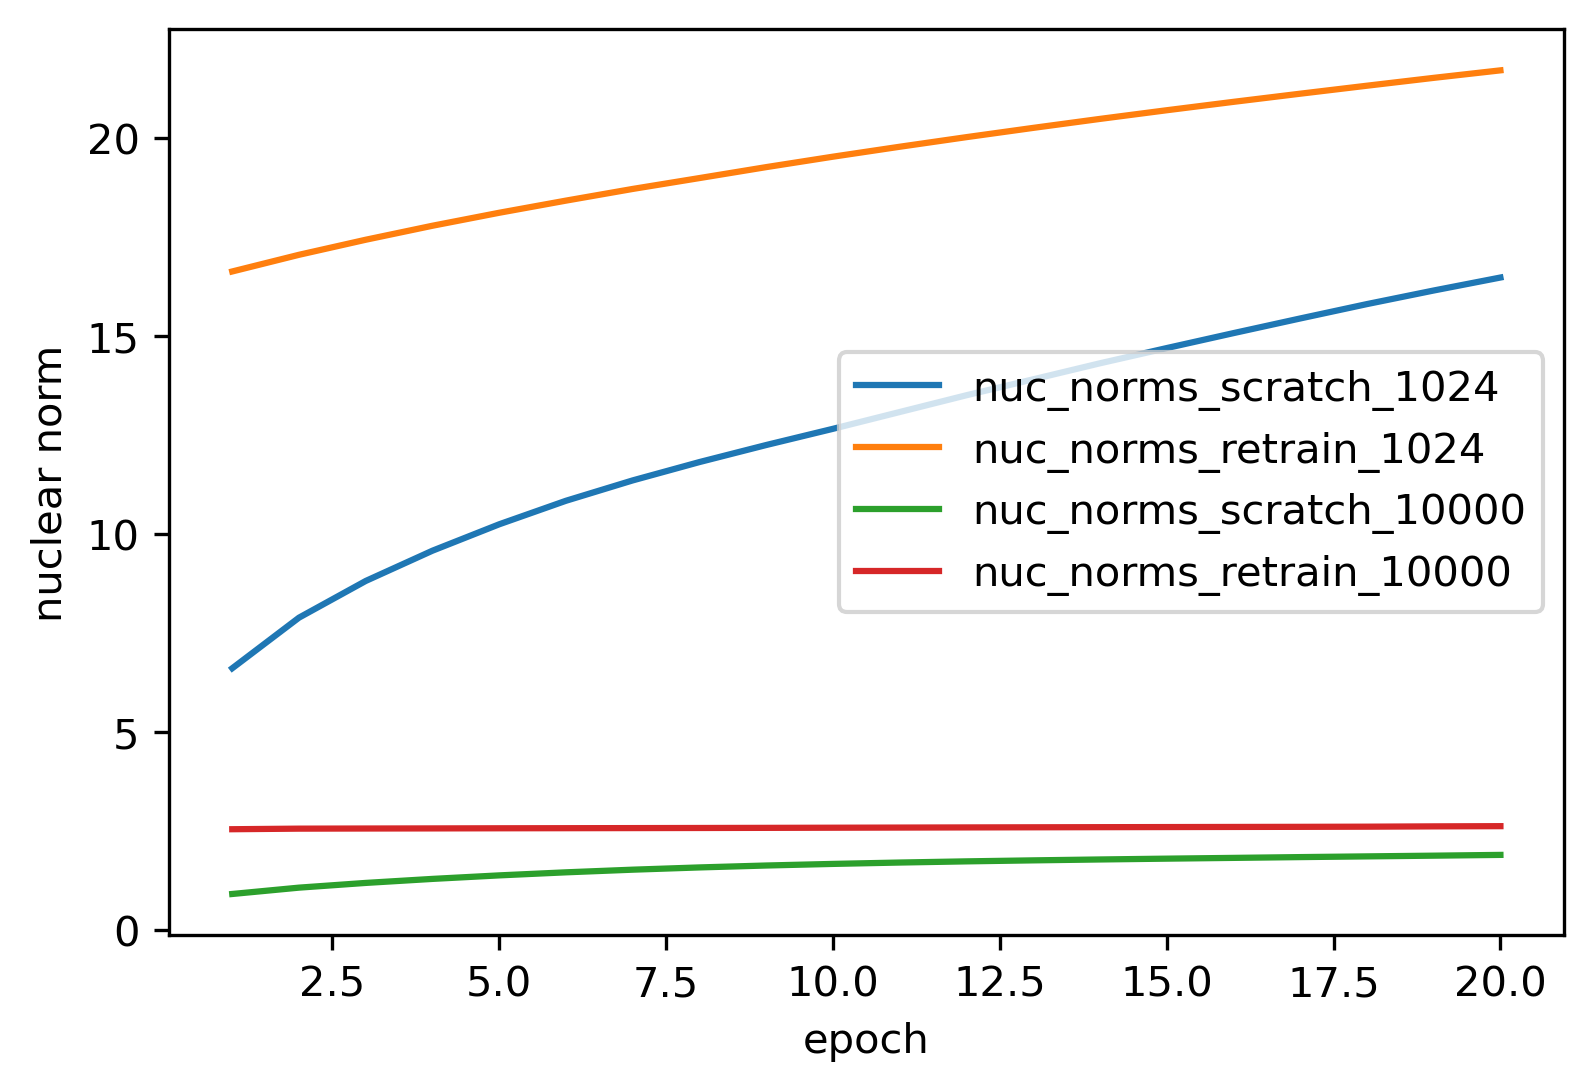

In [28]:
for d in project_dims:
    plt.plot(np.arange(1,21), nuc_norms_scratch[d])
    plt.plot(np.arange(1,21), nuc_norms_retrain[d])
plt.legend(["nuc_norms_scratch_1024", "nuc_norms_retrain_1024", "nuc_norms_scratch_10000", "nuc_norms_retrain_10000"])
plt.xlabel("epoch")
plt.ylabel("nuclear norm")

Text(0, 0.5, 'relative deviation in norm')

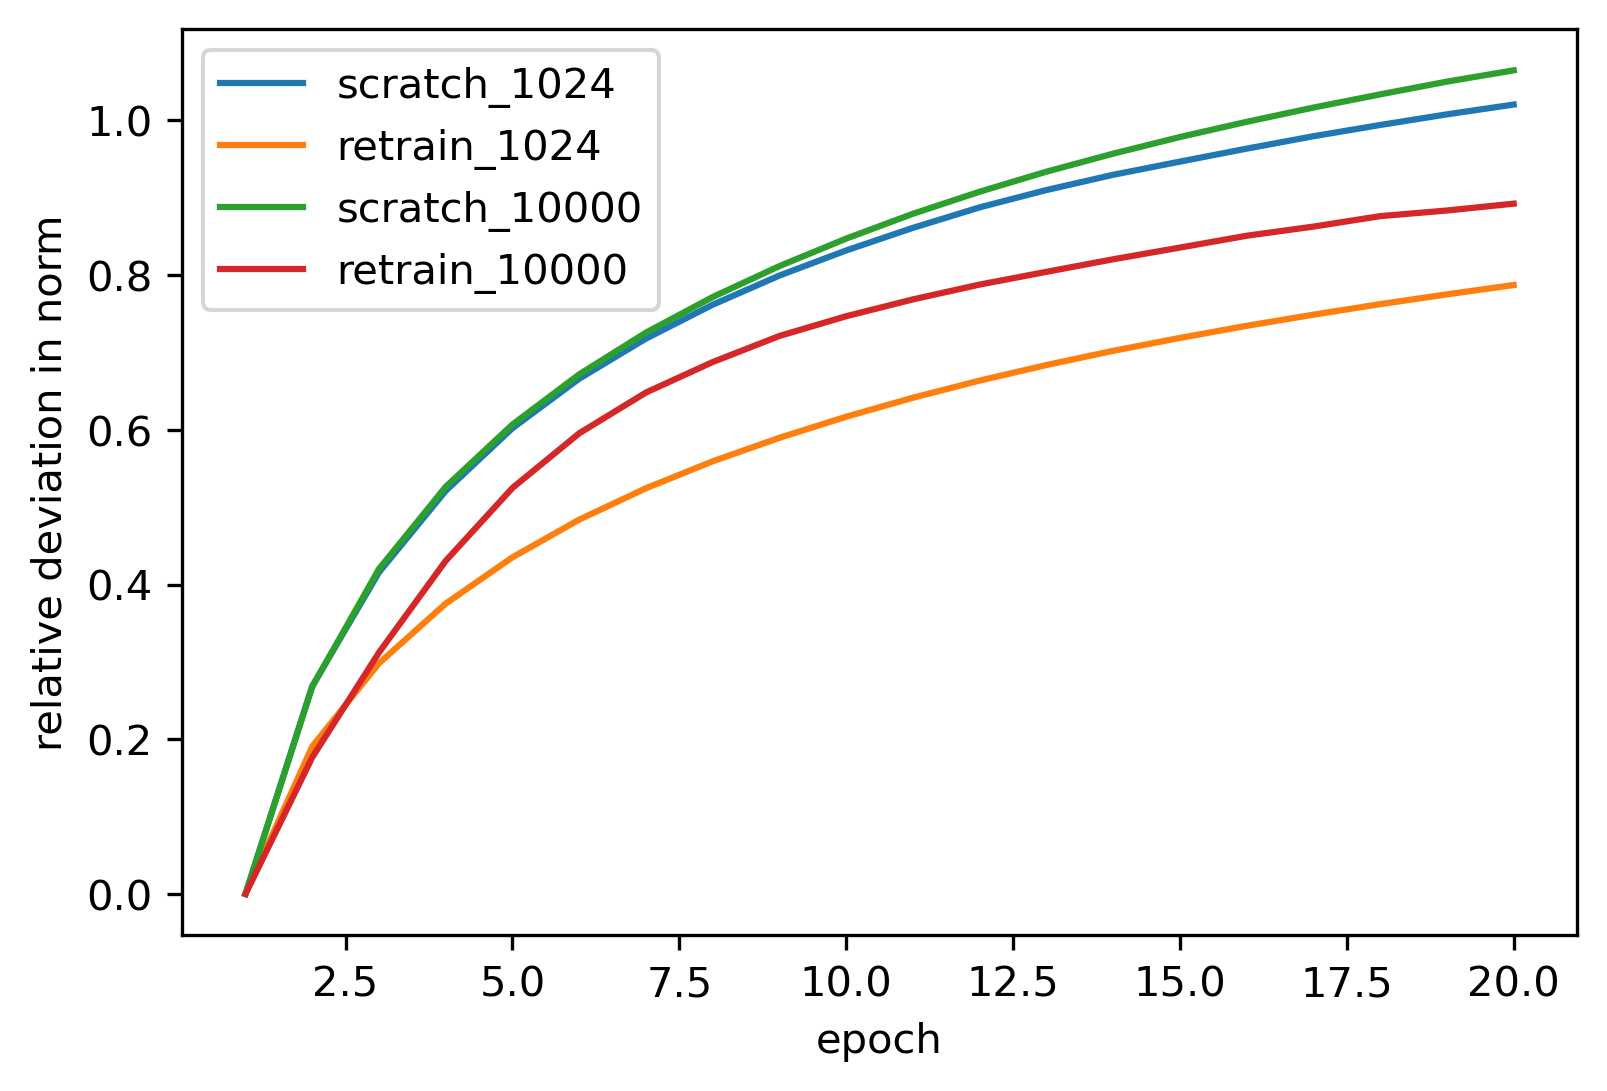

In [27]:
for d in project_dims:
    plt.plot(np.arange(1,21), [torch.norm(A - kernels_scratch[d][0]).cpu()/torch.norm(kernels_scratch[d][0]).cpu() for A in kernels_scratch[d]])
    plt.plot(np.arange(1,21), [torch.norm(A - kernels_retrain[d][0]).cpu()/torch.norm(kernels_retrain[d][0]).cpu() for A in kernels_retrain[d]])
plt.legend(["scratch_1024", "retrain_1024", "scratch_10000", "retrain_10000"])
plt.xlabel("epoch")
plt.ylabel("relative deviation in norm")

In [13]:
for i, x in enumerate(svdvals_dict["scratch_start_1024"]):
    if svdvals_dict["scratch_start_1024"][0]/x > 1e2:
        print(i)
        break
for i, x in enumerate(svdvals_dict["scratch_end_1024"]):
    if svdvals_dict["scratch_end_1024"][0]/x > 1e2:
        print(i)
        break


216
708


In [14]:
for i, x in enumerate(svdvals_dict["scratch_start_10000"]):
    if svdvals_dict["scratch_start_10000"][0]/x > 1e2:
        print(i)
        break
for i, x in enumerate(svdvals_dict["scratch_end_10000"]):
    if svdvals_dict["scratch_end_10000"][0]/x > 1e2:
        print(i)
        break

79
190
